In [168]:
import os
import time
import datetime
import json
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn import metrics
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn

import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils

from util.pos_embed import interpolate_pos_embed
import models_mae
import models_vit

print(np.__version__)
print(pd.__version__)
print(torch.__version__)

path_meta = Path('meta')
path_meta.mkdir(exist_ok=True, parents=True)
path_embeddings = Path('embedding')
path_embeddings.mkdir(exist_ok=True, parents=True)

1.22.2
1.4.1
1.10.2+cu113


### Purpose 目的
Identify the key features/dimensions that the model uses to make determinations in the classification task  

找出模型在分類任務中，用來做判定的關鍵特徵/維度

### How to find key features 如何找出關鍵特徵
- 將全世界的鳥類透過模型編碼(壓縮)成形狀為(1, dimension)的高維向量
    - 這個高維向量又稱為 embedding(representation, latent vector)
    - 在模型中以n=dimension組數值，編碼、描述鳥類的型態
    - 在ViT模型中， 圖塊嵌入(patch embedding)匯聚圖像資訊為類別表徵(cls embedding)，並使用cls embedding作為下游的分類任務使用 

- 借用<font color=lightgreen size=4> GradCam</font>概念，使用各類別(y)反向求導，求出對該類別有較大反應的導數所在維度(位於embedding的哪些維度上)

- 分類器
    - inputs: 
        - embedding。這裡使用cls embedding
    - outputs: 
        - classes。預測的類別
    - classifier:
        - ~~dense layer(full connected layers)*2~~
        - ViT內，在transformer模塊與外用來產生分類預測間是線性連結層，可以直接取出使用
            - transformer模塊外的最後兩層   
                - (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
                - [x] (head): Linear(in_features=768, out_features=1486, bias=True)
                <br><table align=left><tr><td bgcolor=green >注意!! head後沒有經過活化層，因此導數會得到負值</td></tr></table><br><br>

            - 使用目前下游分類任務表現最好的iNatFT encoder
                - (架構是使用eBirdPT NPon, cls_token的MAE encoder)  

- 關鍵特徵的決定採用投票方式
    - 採用iNatFT encoder的head(Linear layer)作為分類器(對應"種"層級的分類任務)
    - 使用GradeCam方法取得各個物種為單位的grad數值
    - 取得以"科"為單位的導數數值
        - 計算以科為單位的 mean/ medium    




# Prepare data

In [2]:
encoder_version='eBirdFT' # 'iNatFT', 'eBirdFT' or 'eBirdPT',
norm_pixel = 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'eBirdTop100' #  'iNat', 'eBird', 'eBirdTop100'

path_model = Path('output_dir')

print(f'Encoder  : {encoder_version}')
if encoder_version=='iNatFT':
    ck = path_model/'ebird_NPon_FT_cls_vit_base_checkpoint-99.pth'   #　iNaturalist finetuned MAE
    n_classes = 1486
elif encoder_version=='eBirdPT':
    ck = path_model/'ebird_LP_cls_2fc_vit_base_checkpoint-89.pth'   #　Ebird pretrained MAE
    n_classes =1486
elif encoder_version=='eBirdFT':
    ck = path_model/'ebird_NPon_eBirdFT_cls11186_vit_base_checkpoint-49.pth'  #　eBird finetuned MAE
    n_classes = 11186

v_embedding = f'NP{norm_pixel}(Pretrain)_{encoder_version}{token}(Encoder)_{data_src}(Data)'
print(f'Embedding version : {v_embedding}')

 

Encoder  : eBirdFT
Embedding version : NPon(Pretrain)_eBirdFTcls(Encoder)_eBirdTop100(Data)


In [3]:
%%time

data_path = '../../shared/iNaturalist_2021'

if data_src == 'eBird':
    val_data = 'val_ebird'
    meta_data =  '../../shared/iNaturalist_2021/meta/val_ebird.csv'
elif data_src == 'iNat':
    val_data = 'val'
    meta_data =  '../../shared/iNaturalist_2021/meta/val.csv'
elif  data_src == 'eBirdTop100':
    data_path = '../../shared/eBird/download_ebird/downloaded'
    val_data = 'jpg_top100'
    meta_data =  '../../shared/eBird/download_ebird/meta/jpg_top100_meta5.csv'
 

CPU times: user 4 µs, sys: 7 µs, total: 11 µs
Wall time: 22.6 µs


### Load meta

In [4]:
col_obj2cat = ['Format', 'Accessory', 'Asset_State', 'isInternalUser', 'mediaDownloadUrl', 'Playback', 'Microphone', 'Recorder', 'Taxon_Category', 
               'Age/Sex', 'Asset_Tags', 'Order', 'Behaviors', 'Country', 'Parent_Dir', 'Family', 'Background_Species', 'Genus', 'State', 'County']
col_type = {col_: type_ for col_, type_ in  zip (col_obj2cat, ['category']*len(col_obj2cat))}


In [5]:
%%time
assert data_src == 'eBirdTop100'

meta_data =  '../../shared/eBird/download_ebird/meta/jpg_top100_meta5.csv'
df_meta =  pd.read_csv(meta_data, index_col=0, dtype=col_type)

col_label = ['Label']    
col_basic = ['ML_Catalog_Number', 'Dir_FName']
col_file = ['Dir_FName', 'Parent_Dir', 'Sci_N']
col_taxon = ['Order', 'Family', 'Genus', 'SCI_NAME_2021', 'Sci_Name', 'Parent_Species', 'Taxon_Category']
col_geo = ['Country', 'Latitude', 'Longitude']
col_time = ['Year', 'Month', 'Day']
col_rating = ['Average_Community_Rating','Number_of_Ratings']
col_sel = col_label + col_basic + col_taxon + col_geo + col_time + col_rating
df_meta = df_meta[col_sel].copy()

assert df_meta.Label.dtype == 'int64'

print(f'# of Order : {df_meta.Order.nunique()}')
print(f'# of Family : {df_meta.Family.nunique()}')
print(f'# of Genus: {df_meta.Genus.nunique()}')

print(df_meta.columns)


# of Order : 41
# of Family : 249
# of Genus: 2295
Index(['Label', 'ML_Catalog_Number', 'Dir_FName', 'Order', 'Family', 'Genus',
       'SCI_NAME_2021', 'Sci_Name', 'Parent_Species', 'Taxon_Category',
       'Country', 'Latitude', 'Longitude', 'Year', 'Month', 'Day',
       'Average_Community_Rating', 'Number_of_Ratings'],
      dtype='object')
CPU times: user 8.52 s, sys: 984 ms, total: 9.51 s
Wall time: 9.51 s


In [6]:
   
# val_data = 'ebird_finetune/train'
# imgs_path = Path(data_path, val_data)
# # imgs_path = Path('../../shared/iNaturalist_2021/val_ebird')
# print(imgs_path)
# files_path_ = [f for f in imgs_path.glob('**/*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

# # exlude .ipynb files
# files_path_ = [f for f in files_path_ if not f.name.startswith('.')] 
# files_path_.sort()

# print(f'Meta data :  "{Path(meta_data).name}"')

files_path_  = list(data_path + '/' +  val_data + '/' + df_meta.Dir_FName	+ '.jpg')
labels = df_meta.Label.values

print(len(files_path_ ))
assert len(files_path_) == len(labels)
assert  df_meta.Label.dtype == 'int64'

896555


# Training a simple classification model
- detal training process in `train_family_classifier.ipynb`

## Load Linear Classifier 

In [32]:
# Define model
 
n_classes = 249
n_neurons = 256
dim=768

class Family_Predictor(nn.Module):
    def __init__(self, in_features=dim*2 , n_neurons=n_neurons, n_classes=n_classes ):
        super().__init__()
#         super().__init__()
        self.family_Predictor = nn.Sequential(
            nn.Linear(in_features, n_neurons),
            nn.LeakyReLU(negative_slope=0.02, inplace=True),
            nn.Linear(n_neurons, n_classes),
        )

    def forward(self, x):
        pre = self.family_Predictor(x)
        return pre 
    
model = Family_Predictor(in_features=dim*2 , n_neurons=n_neurons, n_classes=n_classes) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Family_Predictor(
  (family_Predictor): Sequential(
    (0): Linear(in_features=1536, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.02, inplace=True)
    (2): Linear(in_features=256, out_features=249, bias=True)
  )
)

In [40]:

model_name = f'Family_Predictor_Batch500'
path_model = Path('meta/family_Predictor')
path = path_model/f'{model_name}.pth'
 

# load_checkpoint(model, path, optimizer=None):
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
epoch_ = checkpoint['epoch']
best_metric_ = checkpoint['best_metric']
    
print(f'best__metric : {best_metric_:.4f}')
print(f'{model_name}.pth loaded!')
# model.to(device)
model.to(device)

best__metric : 95.6067
Family_Predictor_Batch500.pth loaded!


Family_Predictor(
  (family_Predictor): Sequential(
    (0): Linear(in_features=1536, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.02, inplace=True)
    (2): Linear(in_features=256, out_features=249, bias=True)
  )
)

# Embedding 維度堆疊轉正


## Get the gradient vectors(Degree of Concern about Features) 
找出分類器中，分類結果對於各維度的關注度(各類別反向傳播後的導數)
- 關注度
    - 模型根據預測結果反向傳播回去後，特徵(embedding)的導數。
    - 代表模型對該類別預測時，是根據那些特徵作為判斷依據
    - 有較大的數值(關注度/導數)表示，該權重位置(維度)對於分類器預測該類別是重要的
- 實作`get_grad()函式`
- 從線性分類器反向傳播中取得各類別對應的導數
- 以物種為單位

###  Implement the `get_grad()` function

In [50]:
def get_grad(inputs:np.array, model, labels:np.array=None, n_classes:int=n_classes, **kwards)-> (torch.tensor, np.array):
    '''
    inputs : latent vectors /embeddings / features.  shape : (n_batch, dim)
    labels : labels of inputs. (Taxon unit such as : Species, Family, etc.) shape : (n_batch, n_classe)
    model(classifier) : simple fc layer
    outputs : gradients of inputs, label
    ''' 
    model.eval()
    model.zero_grad()
    
    # Set required gradients
    # features = inputs.clone().detach().requires_grad_(True)
    features = Variable(torch.tensor(inputs).to(device)  , requires_grad=True)
    
    pred = model(features)  # (n_batch, n_classe)
    
    # Whether to use the ground truth label, or predicted by the classifier
    if labels is None:                                
        labels = np.argmax(pred.detach().numpy(), axis=1)  # return (n_batch, n_classes)

    # one_hot encoding labels 
    one_hot = F.one_hot(torch.tensor(labels) , num_classes=n_classes).to(device) # (n_batch, n_classe)
    
    # Elementwise multiply of two matrix/vectors to get scalar, then do backpropogation
    # torch.mul(pred, one_hot).sum().backward() is same as pred.backward(one_hot) 
    pred.backward(one_hot)                             
    
    # grads of embeddings. shape:(n_batch, dim). 
    inputs_grad_ = features.grad.clone().detach()
    
    return inputs_grad_, labels


In [27]:
# embeddings = np.load(path_embeddings/file_)['embedding']
# print(embeddings.shape)

### Get gradients from embeddings

In [28]:
%%time
file_ = f'embeddings_{v_embedding}.npz'

# print(f'{file_}')
# np.savez_compressed(path_embeddings/file_, embedding=embeddings.cpu().numpy() )
# print(f'{file_} saved')
# np.save(path_embeddings.joinpath(file_) , embeddings)b
embeddings = np.load(path_embeddings/file_)['embedding']
print(embeddings.shape)



(896555, 768)
CPU times: user 14.7 s, sys: 1.12 s, total: 15.8 s
Wall time: 15.9 s


##### stack the dimensions to turn negative values into positive values

In [12]:
f_pos = np.where(embeddings > 0, embeddings, 0)               # 保留正值，將其他維(負值)設為0 
f_neg = np.abs(np.where(embeddings < 0, embeddings, 0))       # 保留負值，將其他維(正值)設為0，最後取絕對值  
embeddings_stacked = np.concatenate((f_pos, f_neg), axis=1)   # 將原本的n為堆疊為n*2維 shape = (896195, 1536)
print(embeddings_stacked.shape)

_, dim_stacked = embeddings_stacked.shape
print(dim_stacked)

(896555, 1536)
1536


In [18]:
# filter label > 0
mask_label_positive = df_meta.Label >= 0
# embeddings = embeddings_ori[mask_label_positive]
# print(embeddings.shape)

In [23]:
family_list = list(df_meta.Family.dropna().unique())
family_list.sort()
print(len(family_list))

fam2digit = dict(zip(family_list, range(len(family_list))))
fam2digit.items()

labels = df_meta[mask_label_positive].Family.map(fam2digit).values  # 科名編碼
print(f'labels  : {labels.shape}')

n_classes = len(fam2digit)
print(f'n_classes  : {n_classes}')

249
labels  : (896195,)
n_classes  : 249


In [57]:
# # %%time
# s = 0
# slice_ = 1000
# # e = s + interval 
# n_iter = int(np.ceil(embeddings_stacked[mask_label_positive].shape[0] / slice_))

# labels_pred = [] 
# start_time = time.time()
# for i in range(n_iter):
#     grads_, labels_ = get_grad(embeddings_stacked[mask_label_positive][s : s + slice_], 
#                                model, 
#                                labels=labels[s : s + slice_], 
#                                n_classes=n_classes
#                               )

#     grads = grads_ if i==0 else torch.concat([grads, grads_])
#     labels_pred += list(labels_)
#     s += slice_

#     passing_time = str(datetime.timedelta(seconds=int(time.time() - start_time )))
#     info = f'Progress:{i+1:4,d}, {100*(i+1)/n_iter:6.2f}% ' 
#     info += f'| Time: {passing_time}. | Grad_shape: {grads.shape}.' 
#     print(info, end='\r')
#     # break


In [58]:
file_grad = f'grad(withLabels)_eBirdPT_NP{norm_pixel}_{token}(Pretrain)_{encoder_version}(Finetune)_{data_src}(data)_{model_name}'

# np.savez_compressed(path_embeddings/f'{file_grad}.npz', gradients=grads.cpu().numpy())
# print(f'{file_grad} saved')

grads = np.load(path_embeddings/f'{file_grad}.npz')['gradients']
print(grads.shape)

grad(withLabels)_eBirdPT_NPon_cls(Pretrain)_eBirdFT(Finetune)_eBirdTop100(data)_Family_Predictor_Batch500 saved
(896195, 1536)


''

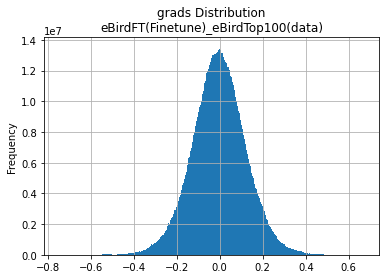

In [60]:
fig, ax = plt.subplots(figsize =(6,4) )
ax.hist(grads.reshape(-1,1), bins=500)
title = f'grads Distribution\n{encoder_version}(Finetune)_{data_src}(data)'

ax.grid(True)
# ax.set_yscale('log')
ax.set(title=title,  ylabel='Frequency')
;

3879


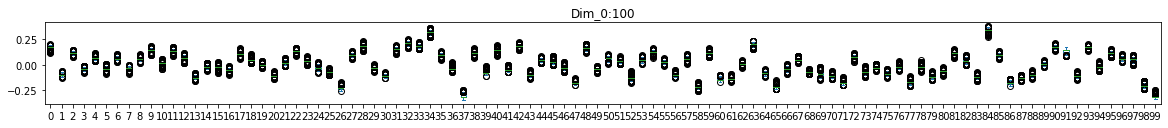

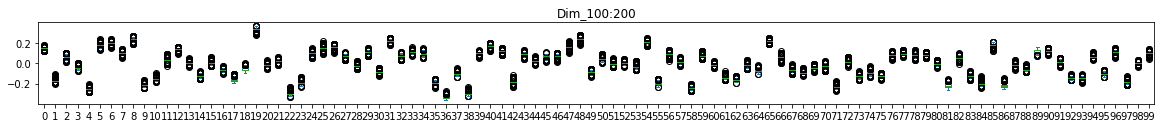

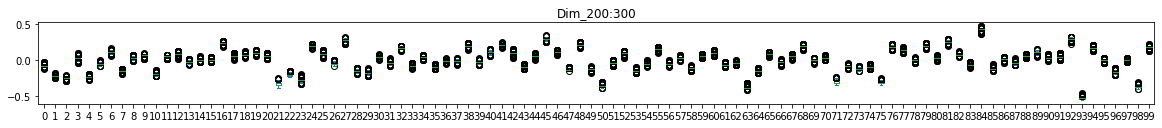

In [61]:
ge_ = "Accipiter"
idx_ = df_meta[mask_label_positive].query('Genus == @ge_').index


# idx_ = df_meta[mask_label_positive].query('Label == 2').index
print(idx_.size)

figsize=(20, 1.5)
s =0 ; interval=100
n, dim = grads.shape
n_iter = int(dim/100)+1 
for i in range(n_iter):
    if i ==3: 
        break 
    pd.DataFrame(grads[idx_, s:s+interval]).plot.box(title=f'Dim_{s}:{s+interval}', figsize=figsize);
    s += interval
    


CPU times: user 8min 53s, sys: 4min 2s, total: 12min 56s
Wall time: 34.4 s


''

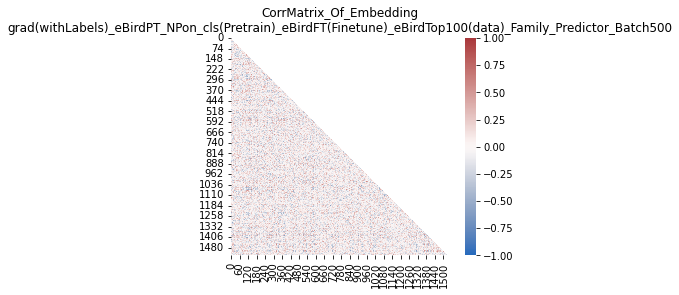

In [62]:
%%time

corr_matrix = np.corrcoef(np.transpose(grads))

# 取矩陣下半三角形
mask =  np.triu(np.ones_like(corr_matrix, dtype=bool))

title = f'CorrMatrix_Of_Embedding\n{file_grad}'
fig, ax = plt.subplots(figsize=(6, 4) )
ax.set_title(title)
sns.heatmap(corr_matrix, vmax=1, vmin=-1, center=0, square=True, 
            mask=mask,
            cmap='vlag', ax=ax)
# fig.savefig(f'embedding/{title}.jpg', bbox_inches='tight',)
;

/home/esslab/anaconda3/envs/mae/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:568: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


''

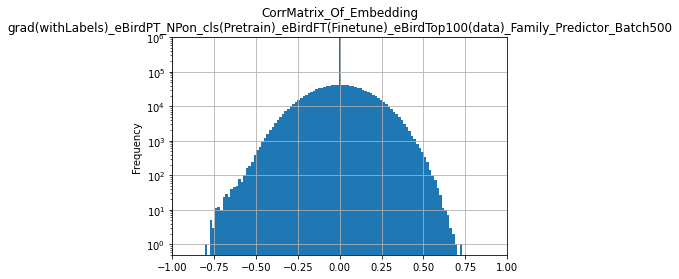

In [63]:
xlim=(-1,1)
ylim=(0,1e6)
# k=-1 ，排除斜對角的數值(均為1.0) 
fig = (pd.DataFrame(np.tril(corr_matrix ,k=-1))
       .stack()
       .plot(kind='hist', title=title, bins=100, grid=True, logy=True, xlim=xlim, ylim=ylim)
      ).get_figure()
# fig.savefig(f'embedding/{title}.jpg', bbox_inches='tight',)
;

# Determine key features by voting on 'Family' level
根據分類層級(科)投票決定關鍵特徵

### Mean of Concern Degree about Features on species/genus
- 找出每科的 top N 個重要分類特徵 (i.e. 對分科有最大影響力的 top N 維度)，並將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。我們視低維度的關鍵特徵為同時具有分辨力 (recognition) 與代表性 (representation) 的蛾標本影像特徵，並用於後續的分析與視覺化的解釋。
- 我們借用 Grad-CAM 的概念以找出分科的重要外觀特徵，透過反向傳播演算法 (back propagation) 求出分科模型中對應於每個輸入值的 gradient vector，是為特徵關注度向量。我們在此計算每個物種的平均特徵關注度，並以 voting 的方式，決定每個科的重要特徵。
- Voting 的規則是，先從物種平均特徵關注度的向量中，找出最大的 N 個值的位置，每個位置視為得到一票；接著算出每個科當中總得票最高的N個位置，即可選出 N 個重要特徵。最後將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。 

- 建立:科-物種"索引

In [64]:
metric = 'Median' # 'Mean', 'Median'

In [107]:

def pool_grads(grads, taxon_list:list=None, metric:str='Mean', df:pd.DataFrame=None ):
    
    for i, cls_ in enumerate(taxon_list):
        index  = df.query(f"{taxon_unit} == @cls_").index.values
            
        if metric == 'Median':
            grads_pool_ = np.median(grads[index], axis=0).reshape(1,-1)
        elif  metric == 'Mean':
            grad_pool_ = np.mean(grads[index], axis=0).reshape(1,-1)

        grads_pool = grads_pool_ if i == 0 else  np.concatenate([grads_pool_, grads_pool])
    
        print(f'{i:4,d}. shape : {grads_pool.shape} |  {taxon_unit} - {cls_} ', end='\r')
    return grads_pool
    

- Species

In [108]:
%%time

taxon_unit = 'Label' # Species
taxon_list = np.sort(df_meta[mask_label_positive][taxon_unit].dropna().unique())
df_ = df_meta[mask_label_positive].reset_index()  

grads_sp_mean = pool_grads(grads, taxon_list , metric, df=df_ )
print('\n', grads_sp_mean.shape)

11,185. shape : (11186, 1536) |  Label - 11185 
 (11186, 1536)
CPU times: user 1min 55s, sys: 14.1 s, total: 2min 9s
Wall time: 2min 6s


- Genus

In [109]:
%%time
taxon_unit = 'Genus'
taxon_list = np.sort(df_meta[mask_label_positive][taxon_unit].dropna().unique())
df_ = df_meta[mask_label_positive].reset_index()  

grads_genus_mean = pool_grads(grads, taxon_list , metric, df=df_ )
print('\n', grads_genus_mean.shape)

2,294. shape : (2295, 1536) |  Genus - Zosterornis is   s 
 (2295, 1536)
CPU times: user 49.3 s, sys: 325 ms, total: 49.6 s
Wall time: 49.1 s


### 找出關鍵特徵數量(N-union)
- 以最小但又具足夠鑑別度的 N 與 N-union 來描述與代表科的特徵。我們窮舉 N = 1 ~ n_topk 這個範圍中對應的 N-union 個關鍵特徵。
- 基於每個物種在關鍵特徵空間中的 embedding，依科計算分群的三個指標 (Silhouette Coefficient, Calinski and Harabasz score, 與 Davies-Bouldin score)
    - 標準化並加總評估後得到當 N=-, N-union=- 時有最佳的科分群結果，約為總特徵數的 - % (-/768)。

#### Convert the "Degree of Concern about Features" to "Key Features" on mean of species 

- 物種均值的特徵關注度(top_n)
    - 在物種層級指定top_n個重要維度
    - 蒐集對應top_n特徵對應的特徵位置指標
    - 依據top_n位置將關注度值轉為one_hot編碼(1 or 0)
    - 得到以物種均值為單位的one hot編碼格式的特徵關注度數值(即每個物種1票)
- 儲存 對應的 top_n: index_N of Spesies

In [106]:
def one_hot_topk(inputs:np.array, n_topk:int)->np.array:
    '''
    encoding inputs(n, dim) to one_hot format(0 or 1) 
    threshod depends on quantile of topk for each sample
    encoding : x = 1 if x > q_topk else 0
    '''
    assert len(inputs.shape)==2
    n, dim = inputs.shape

    # calculate quantile of topk for each sample. 
    q_topk = np.quantile(inputs, q=(dim-n_topk)/dim, axis=1)   # shape : (n,)
    # broadcast quantile_topk from (n,) to (n, dim)
    q_topk = np.repeat(q_topk.reshape(n,-1), dim, axis=1)     
    # encoding : x = 1 if x > q_topk else 0
    
    inputs_one_hot_topk = np.where(inputs >= q_topk, 1, 0)

    
    return inputs_one_hot_topk


In [69]:
taxon_unit = 'Species'
# taxon_unit = 'Genus' # 'Species' or 'Genus'
if taxon_unit == 'Genus':
    grads_mean = grads_genus_mean
elif taxon_unit == 'Species':
    grads_mean = grads_sp_mean

print(grads_mean.shape)

(11186, 1536)


In [70]:
%%time

n_topk = 5
grads_oh_topk = one_hot_topk(grads_mean, n_topk)
print(grads_oh_topk.shape)

# assert each sum of each dimension per data is equal to n_topk
assert (np.sum(grads_oh_topk, axis=1) == n_topk).all(), f'Sum in dim {np.where(np.sum(grads_oh_topk, axis=1) != n_topk)[0]}  \
is not equal to n_topk' 
# assert sorted index of each dimension per data is of "inputs" is same as "inputs_one_hot_topk"
assert (np.sort(np.argsort(grads_mean,)[:, -1 -(n_topk-1): ])  ==  
    np.sort(np.argsort(grads_oh_topk)[:, -1 -(n_topk-1): ])).all()

(11186, 1536)


AssertionError: Sum in dim [584]  is not equal to n_topk



####  Combine the key features of all families to obtain N-union key features
算出每個科當中總得票最高的N個位置，即可選出 N 個重要特徵。最後將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。
- 根據"科-物種"索引各科下各物種的top_n個重要維度
- 將各物種的top_n個重要維度透投票加總(one_hot編碼後每個物種/屬1票)
- 取得以科為單位的N-union重要維度
- ~~one_hot 編碼 科為單位的N-union重要維度~~
    - 排序各科前top_n重要維度(將投票數voting轉換為排序)
    - x = 1 if x > 0 else 0
- 儲存 對應的 top_n: index_N_union of Family
    

##### Voting on Family level

In [71]:
if taxon_unit == 'Genus':
    family_index = (df_meta[mask_label_positive].groupby(['Family', 'Genus']).count().query('ML_Catalog_Number>0').reset_index()[['Family', 'Genus']]) 
elif taxon_unit == 'Species':
    family_index = (df_meta[mask_label_positive].groupby(['Family', 'Label']).count().query('ML_Catalog_Number>0').reset_index()[['Family', 'Label']]) 
# elif taxon_unit == 'Species':
    # family_index = (df_meta.groupby(['family', 'Sci_Name']).count().reset_index()[['family', 'Sci_Name']])
family_index

,Family,Label
0,Acanthisittidae,3090
1,Acanthisittidae,3091
2,Acanthizidae,3092
3,Acanthizidae,3093
4,Acanthizidae,3094
...,...,...
11181,Vireonidae,9528
11182,Vireonidae,9529
11183,Vireonidae,9530
11184,Vireonidae,9531


In [78]:
%%time
# Voting on Family level to get the key features of all families  
# n, dim = grads_mean_topk.shape
def get_voting_family(grads_oh_topk:np.ndarray=None): 
    for i, family_ in enumerate(family_index.Family.unique()):
        index_fm = family_index.query("Family == @family_").index.values
        voting_family_ = np.sum(grads_oh_topk[index_fm], axis=0, keepdims=True)  # (1, dim)
        # assert voting_family_.size ==  dim      # dim 

        voting_family = voting_family_ if i==0 else np.concatenate([voting_family_, voting_family])

        print(f'{i:3,d}. shape : {voting_family.shape} | Family : {family_:20s} ', end='\r')
    return voting_family

voting_family = get_voting_family(grads_oh_topk)
print('\n', voting_family.shape)
voting_family 

248. shape : (249, 1536) | Family : Zeledoniidae         
 (249, 1536)
CPU times: user 321 ms, sys: 16.8 ms, total: 338 ms
Wall time: 317 ms


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

- Calculate the n_topk positions with the highest total votes in each Family  
算出每個科當中總得票最高的N個位置

In [25]:
index_ = np.argsort(voting_family, axis=1)[:, -n_topk:]
print(index_.shape)

(249, 5)


In [73]:
voting_Fmy_oh_topk = one_hot_topk(voting_family, n_topk)

# assert each sum of each dimension per data is equal to n_topk
assert (np.sum(voting_Fmy_oh_topk, axis=1) == n_topk).all(), f'Sum in dim : {np.where(np.sum(voting_Fmy_oh_topk, axis=1) != n_topk)[0]}  \
is not equal to n_topk' 
# assert sorted index of each dimension per data is of "inputs" is same as "inputs_one_hot_topk"
assert (np.sort(np.argsort(voting_family,)[:, -1 -(n_topk-1): ])  ==  
    np.sort(np.argsort(voting_Fmy_oh_topk)[:, -1 -(n_topk-1): ])).all()

AssertionError: Sum in dim : [ 19  22  36  45  52  61  76  78  82  96 123 124 126 137 157 170 178 181
 187 210 217 221 229 230 231 238 245 247]  is not equal to n_topk

#### Get the combination of topk - N_union

In [147]:
%%time
topks = range(1 ,51)

n, dim = embeddings.shape
print(n, dim)

taxon_unit = 'Species'
# taxon_unit = 'Genus' # 'Species' or 'Genus'
if taxon_unit == 'Genus':
    grads_mean = grads_genus_mean
elif taxon_unit == 'Species':
    grads_mean = grads_sp_mean

print(grads_mean.shape)

# filter positive grads
grads_mean_pos = np.clip(grads_mean , 0, None) # transform negative grads to 0

index_n_unions = []
for i, topk_ in enumerate(topks) :
    
    # transform grads to voting value on sp or genus level, sort by values
    grads_oh_topk = one_hot_topk(grads_pos, topk_)  
    # voting result at Family level
    voting_family = get_voting_family(grads_oh_topk)  
    # transform voting result according topk
    voting_Fmy_oh_topk = one_hot_topk(voting_family, topk_) 
    # sum the voting results on eaeh diemnsion
    features_topk_families_voting = np.sum(voting_Fmy_oh_topk ,axis=0)  
    
    # get union of voting result
    index_ = np.where(features_topk_families_voting > 0)[0]         # get union from all dimension which voting greater than 0                 
    index_n_union_ = np.where(index_ > dim, index_ - dim, index_)   # unstack dimensions from 'dim + dim' to dim  
    index_n_union_ = np.unique(index_n_union_)                      # remove duplicated dimensions
    
    index_n_unions.append(index_n_union_)
    print(i, topk_, end='\r')

896555 768
(11186, 1536)
CPU times: user 43.3 s, sys: 4.15 s, total: 47.5 s       
Wall time: 46.8 s


In [151]:
np.save(path_embeddings/f'index_n_unions.npy', index_n_unions)
index_n_unions = np.load(path_embeddings/f'index_n_unions.npy', allow_pickle=True)


/home/esslab/anaconda3/envs/mae/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


<AxesSubplot:title={'center':'combination of topk - N_union'}, xlabel='topk', ylabel='n_unions'>

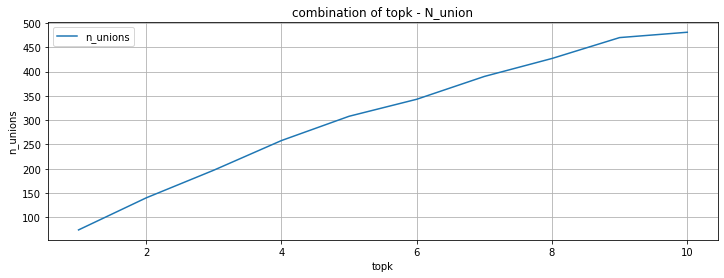

In [150]:
n_unions_  = [len(idxs_) for idxs_ in index_n_unions]
title = "combination of topk - N_union"
figsize = (12,4)

df_Nuniun = pd.DataFrame(n_unions_, index=range(1, len(n_unions_)+1), columns=['n_unions'] )
(df_Nuniun[:10].plot(xlabel="topk", ylabel="n_unions", 
                     grid=True, title=title, figsize=figsize )
)

In [158]:
df_Nuniun = pd.DataFrame(n_unions_, index=range(1, len(n_unions_)+1), columns=['n_unions'] )
df_Nuniun[:10] 


,n_unions
1,74
2,140
3,197
4,258
5,308
6,343
7,390
8,427
9,470
10,481


#### NOTE
-  tok=1 時，	n_unions才小於100
    -   tok=1, n_unions=74 (9.63%)

---

#### Clustering performance evaluation

In [161]:
def get_Nunion_features (features=None, n=None, index_n_unions=index_n_unions):
    index = index_n_unions[n]
    _, dim = features.shape
    mask = ~np.isin(np.arange(dim), index)  # Filtering out non-critical dimensions by reverse selection   
    index_inverse = np.arange(dim)[mask]
    
    features_ = features.copy()             #  Recopy features_ every time, otherwise the original data will be overwritten
    features_[:, index_inverse] = 0         # Freeze the value of the dimension that is not selected to 0
    return features_

In [267]:
n_range = np.arange(50)

In [268]:
%%time
# The score is higher when clusters are dense and well separated
ch_scores = []
for n in n_range:
    features_ = get_Nunion_features (features=embeddings[mask_label_positive], n=n, index_n_unions=index_n_unions)
    score = metrics.calinski_harabasz_score(features_, df_meta[mask_label_positive].Family)
    ch_scores.append(score) 
    print(f'topk : {n}, score : {score:.3f}', end='\r')

CPU times: user 3min 13s, sys: 31.1 s, total: 3min 44s
Wall time: 3min 44s


In [269]:
%%time
# Zero is the lowest possible score. Values closer to zero indicate a better partition.
db_scores = []
for n in n_range:
    features_ = get_Nunion_features (features=embeddings[mask_label_positive], n=n, index_n_unions=index_n_unions)
    score = metrics.davies_bouldin_score(features_, df_meta[mask_label_positive].Family)
    db_scores.append(score) 
    print(f'topk : {n}, score : {score:.3f}', end='\r')

CPU times: user 1h 19min 7s, sys: 2h 59min, total: 4h 18min 7s
Wall time: 6min


In [270]:
# %%time
 
# sil_scores = []
# for n in n_range:
#     features_ = get_Nunion_features (features=embeddings[mask_label_positive], n=n, index_n_unions=index_n_unions)
#     score = metrics.silhouette_score(features_, df_meta[mask_label_positive].Family)
#     sil_scores += score
#     print(f'topk : {n}, score : {score:.3f}', end='\r')

In [279]:
data = [ch_scores, db_scores]
metric_score = (pd.DataFrame(np.array(data).T,
                             index=n_range,
                             columns=["calinski_harabasz", "davies_bouldin"])
                # .reset_index().rename(columns={'index':'topk'})
               )
# metric_score.topk = metric_score.topk + 1
metric_score.index = df_Nuniun.n_unions[:len(n_range)].values

metric_score.to_csv(f'meta/clustering_metric_score_features.csv')
metric_score = pd.read_csv(f'meta/clustering_metric_score_features.csv', header=[0], index_col=0)
metric_score[:5]

,calinski_harabasz,davies_bouldin
74,246.846254,5.273027
140,238.325388,5.228312
197,238.820992,5.197411
258,239.147132,5.179836
308,236.526286,5.181427


best topk : 4, N_uniun 258
Clustering Eval Score : 1.663


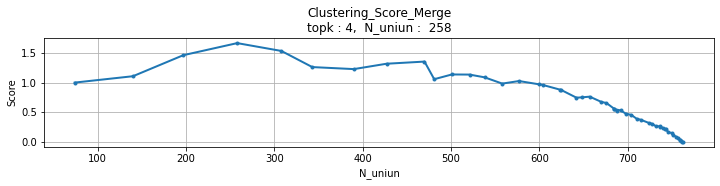

In [280]:
 #　將三個metric標準化處理，取值在0~1。
metric_score.davies_bouldin = metric_score.davies_bouldin*-1  # davies_bouldin為越小越佳，因此先乘上負號
metric_score_ = (metric_score -  metric_score.min()) / (metric_score.max() -  metric_score.min())
# idx = pd.IndexSlice
# metric_score_.loc[:, idx[:, "2D"]].sum(axis=1)
# metric_score_.loc[:, idx[:, "3D"]].sum(axis=1)
metric_score_merge = metric_score_.sum(axis=1)
best_topk =  metric_score_merge.argmax() + 1
print(f"best topk : {best_topk}, N_uniun {metric_score_merge.idxmax()}")  # 檢視分群最佳結果的 N_union
print(f"Clustering Eval Score : {metric_score_merge.max():.3f}")

figsize=(12, 2); marker="."; lw = 2
title = "Clustering_Score_Merge"
title += f"\ntopk : {best_topk},  N_uniun :  {metric_score_merge.idxmax()}"
metric_score_merge.plot(title=title , grid=True, figsize=figsize, lw=lw, marker=marker, xlabel='N_uniun', ylabel='Score');         # 三個指標標準化後加總

# metric_score.silhouette.plot(title="Silhouette_Score",grid=True, figsize=figsize, lw=lw, marker=marker);

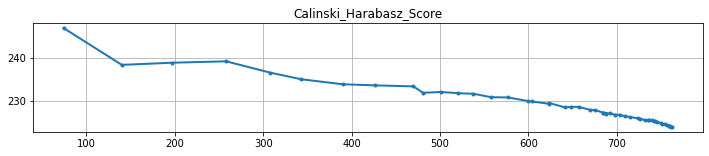

In [281]:
# The score is higher when clusters are dense and well separated
metric_score.calinski_harabasz.plot(title="Calinski_Harabasz_Score",grid=True, figsize=figsize, lw=lw, marker=marker);

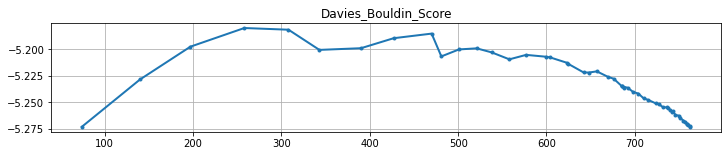

In [275]:
# Zero is the lowest possible score. Values closer to zero indicate a better partition.
metric_score.davies_bouldin.plot(title="Davies_Bouldin_Score",grid=True, figsize=figsize, lw=lw, marker=marker);

##### Note about Clustering performance evaluation:
- topk=4，N-union=258時，有最佳的科分群分數(1.66)，約為總特徵數的 33.59% (258/768)
- 分群評估方法中，由於silhouette_score太過費時，因此本次未納入
- 作圖檢視，clustering結果與metric_score分數一致，並不是使用越多特徵、分群效果就越明顯 

# Understanding the visual significance of key features